## Task 2 & 4: Image Reconstruction and Depth Estimation (50 pts + 30 pts)
Create an "all-in-focus image" using the best result from all scales.

The structure of the algorithm is the following:
- Deblur the entire image for each of scaled kernels.
- Compute reconstruction error $e_k$ for each of the scaled images.
- For small windows around every pixel, compute the error of that pixel,
- Select the minimum and create a depth map with the selected depths.

Preparing data:

In [1]:
from IPython.display import Image
import numpy as np
import cv2
import scipy.io
from lib.deconvolution import flip_kernel
from lib.display_helper import *
from lib.log import log_message

matlab_files = [scipy.io.loadmat("CodedApertureData/filts/filt_scl0"+str(i)+".mat") for i in range(1,10)]
kernels = [flip_kernel(ml_file['filts'][0,3]) for ml_file in matlab_files]
image = cv2.imread('CodedApertureData/cups_board_inp.bmp');
image_gray = cv2.imread('CodedApertureData/cups_board_inp.bmp', 0);

outputs_L2_color = [cv2.imread('output/task1/color_'+str(max(k.shape))+'.png') for k in kernels]
outputs_L2_colorized = [cv2.imread('output/task1/colorized_'+str(max(k.shape))+'.png') for k in kernels]
outputs_Sps_color = [cv2.imread('output/task3/color_150_200_'+str(i)+'.png') for i in range(len(kernels))]
outputs_Sps_color = [cv2.imread('output/task3/colorized_150_200_'+str(i)+'.png') for i in range(len(kernels))]

Computing errors and masks:

In [4]:
from scipy.signal import convolve2d, fftconvolve

def compute_reconstruction_errors(image, kernels, deconvs, filter_size=9):
    (h, w,c) = image.shape
    convs = np.zeros((len(kernels),h,w,c), np.float32)
    for k in range(len(kernels)):
        for i in range(c):
            convs[k,...,i] = fftconvolve(deconvs[k,...,i], kernels[k], 'same')
    errors = image - convs
    e_sq = errors**2
    box_kernel = np.ones((filter_size, filter_size), np.float32)
    approx_errors = np.zeros((len(kernels),h,w,c), np.float32)
    for k in range(len(kernels)):
        for i in range(c):
            approx_errors[k,...,i] = fftconvolve(e_sq[k,...,i], box_kernel, 'same')
    return approx_errors

def compute_reconstruction_masks(approx_errors):
    nkernels = len(approx_errors)
    errors_sum = np.sum(approx_errors,axis=-1)
    errors_sum = np.repeat(errors_sum[...,None], 3, axis=-1)
    contribution_map  = np.argmin(errors_sum, axis=0)
    (h,w,c) = contribution_map.shape
    masks = np.zeros((nkernels,h,w,c), np.float32)
    for k in range(nkernels):
        masks[k,...] = np.where(contribution_map==k, 1, 0)
    return contribution_map, masks

def compute_image_reconstruction(deconvs, masks):
    masked_deconvs = deconvs*masks
    output = np.sum(masked_deconvs, axis=0)
    return output

# coding value as color
# (-1, 1) -> (red, blue)
# http://www.ks.uiuc.edu/Research/vmd/vmd-1.7.1/ug/node76.html
def color_scale(value):
    new_value = value.copy()
    new_value[...,0] = np.clip(-new_value[...,0], 0., 1.) * 255.
    new_value[...,1] = (1. - np.abs(new_value[...,1])) * 255.
    new_value[...,2] = np.clip(new_value[...,2], 0., 1.) * 255.
    return new_value.clip(0,255).astype(np.uint8)

# http://www.ks.uiuc.edu/Research/vmd/vmd-1.7.1/ug/node76.html
def color_scale_legend(kernels):
    min_k = kernels[0]
    max_k = kernels[-1]
    kernel_scale = 5
    sh, sw = kernel_scale*len(kernels)*max(min_k.shape[0],max_k.shape[0]), 40
    padding = 0
    # fill scale line
    display = np.zeros((sh,sw+padding+5*max(min_k.shape[1],max_k.shape[1]),3), np.float32)
    kh = sh/len(kernels)
    for i in range(len(kernels)):
        posy = ((i+1)*sh)/len(kernels) - kh
        val = (i*2)/float(len(kernels)) - 1.
        B = np.clip(-val, 0., 1.) * 255.
        G = (1. - np.abs(val)) * 255.
        R = np.clip(val, 0., 1.) * 255.
        display[posy:posy+kh,-sw:] = [B,G,R]
    # draw kernels
    for i in range(len(kernels)):
        k = kernels[i]
        (kh,kw) = k.shape
        k = cv2.resize(k, (kw*kernel_scale, kh*kernel_scale))
        k = np.repeat(k[...,None], 3, axis=-1)
        posy = ((i+1)*sh)/len(kernels) - kh*5
        display[posy:posy+kh*5,:kw*5] = ((k.copy()+np.min(k))/np.max(k))*255
    return display.clip(0,255).astype(np.uint8)

def display_contribution_map(contribution_map):
    cmap_norm = contribution_map.copy()
    cmap_norm = (cmap_norm/(float(np.max(cmap_norm))/2.)) - 1.
    return color_scale(cmap_norm)
    

Output for L2 color:

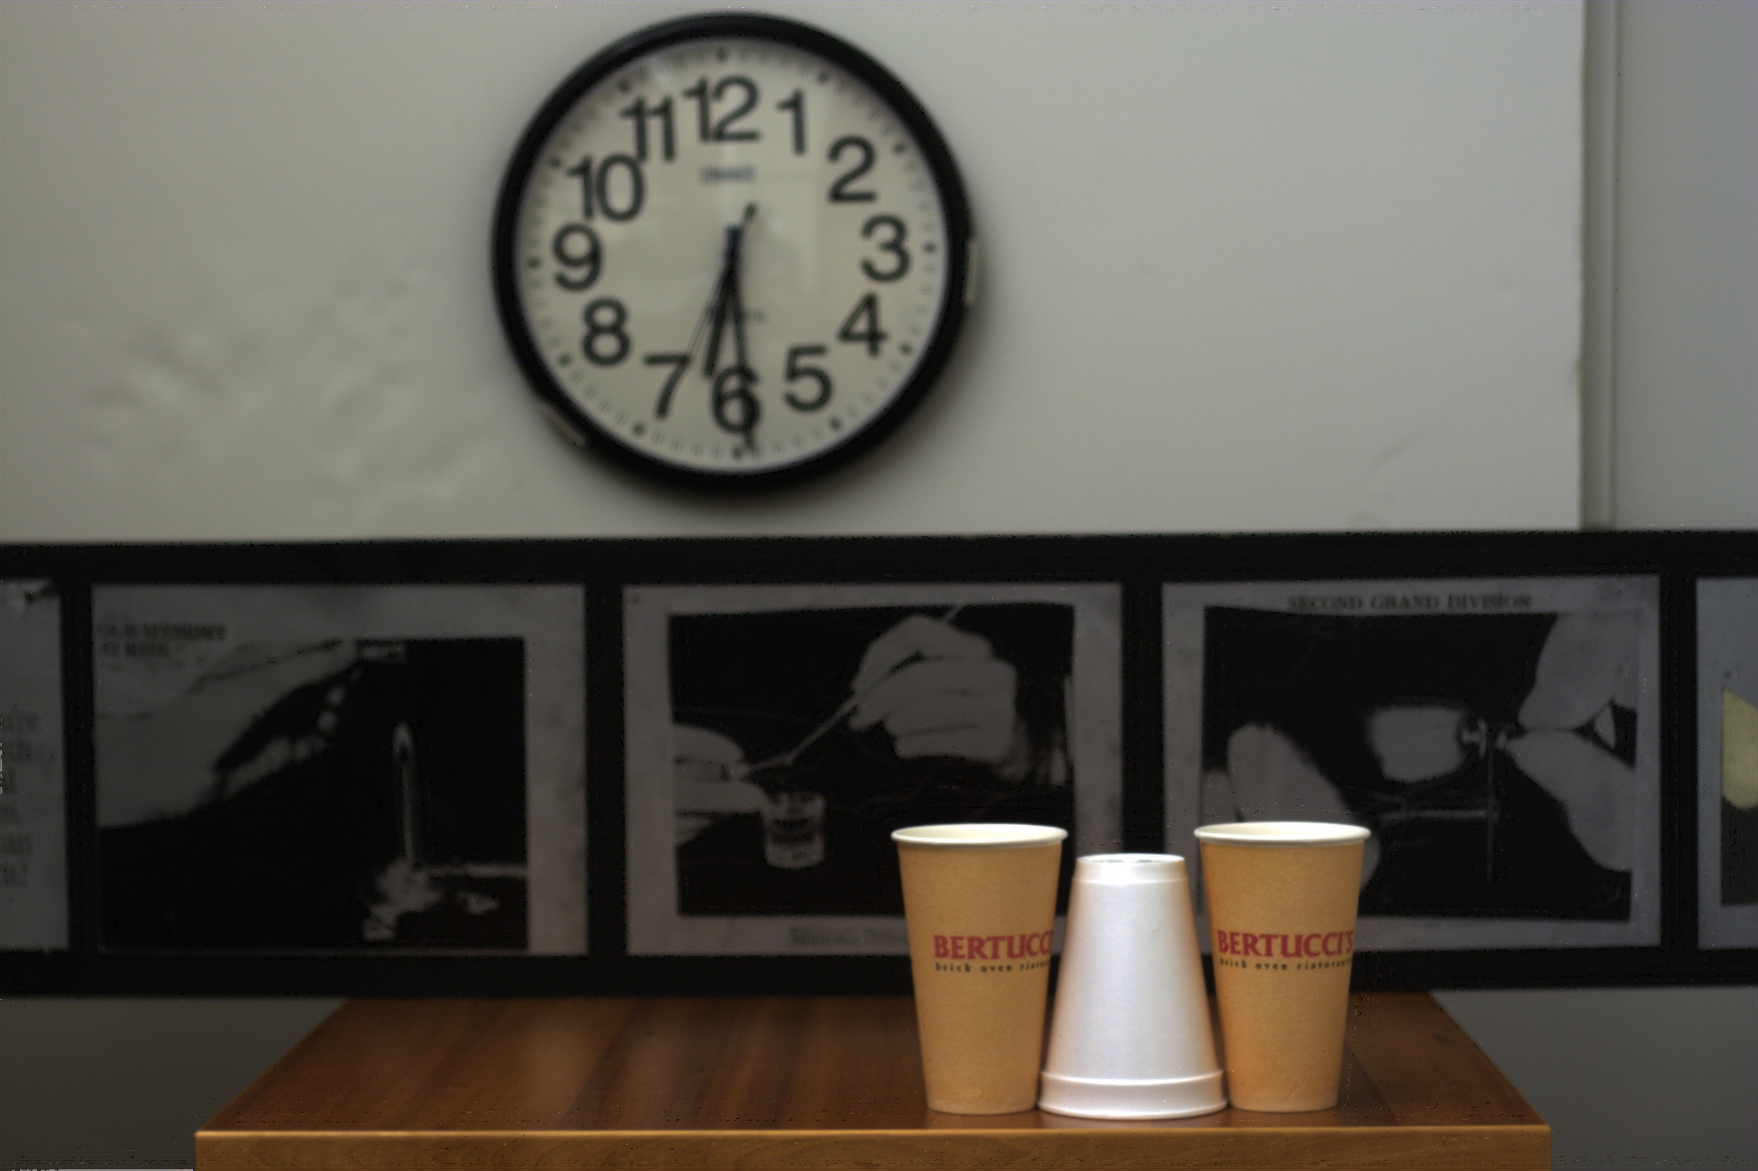

In [11]:
deconvs = np.array(outputs_L2_color)
log_message("Computing reconstruction errors...")
approx_errors = compute_reconstruction_errors(image, kernels, deconvs, 3)
log_message("Computing reconstruction masks...")
contribution_map, masks = compute_reconstruction_masks(approx_errors)
log_message("Computing reconstructed image...")
output = compute_image_reconstruction(deconvs, masks)
output_path = 'output/task2.png'
cv2.imwrite(output_path, output)
Image(output_path)

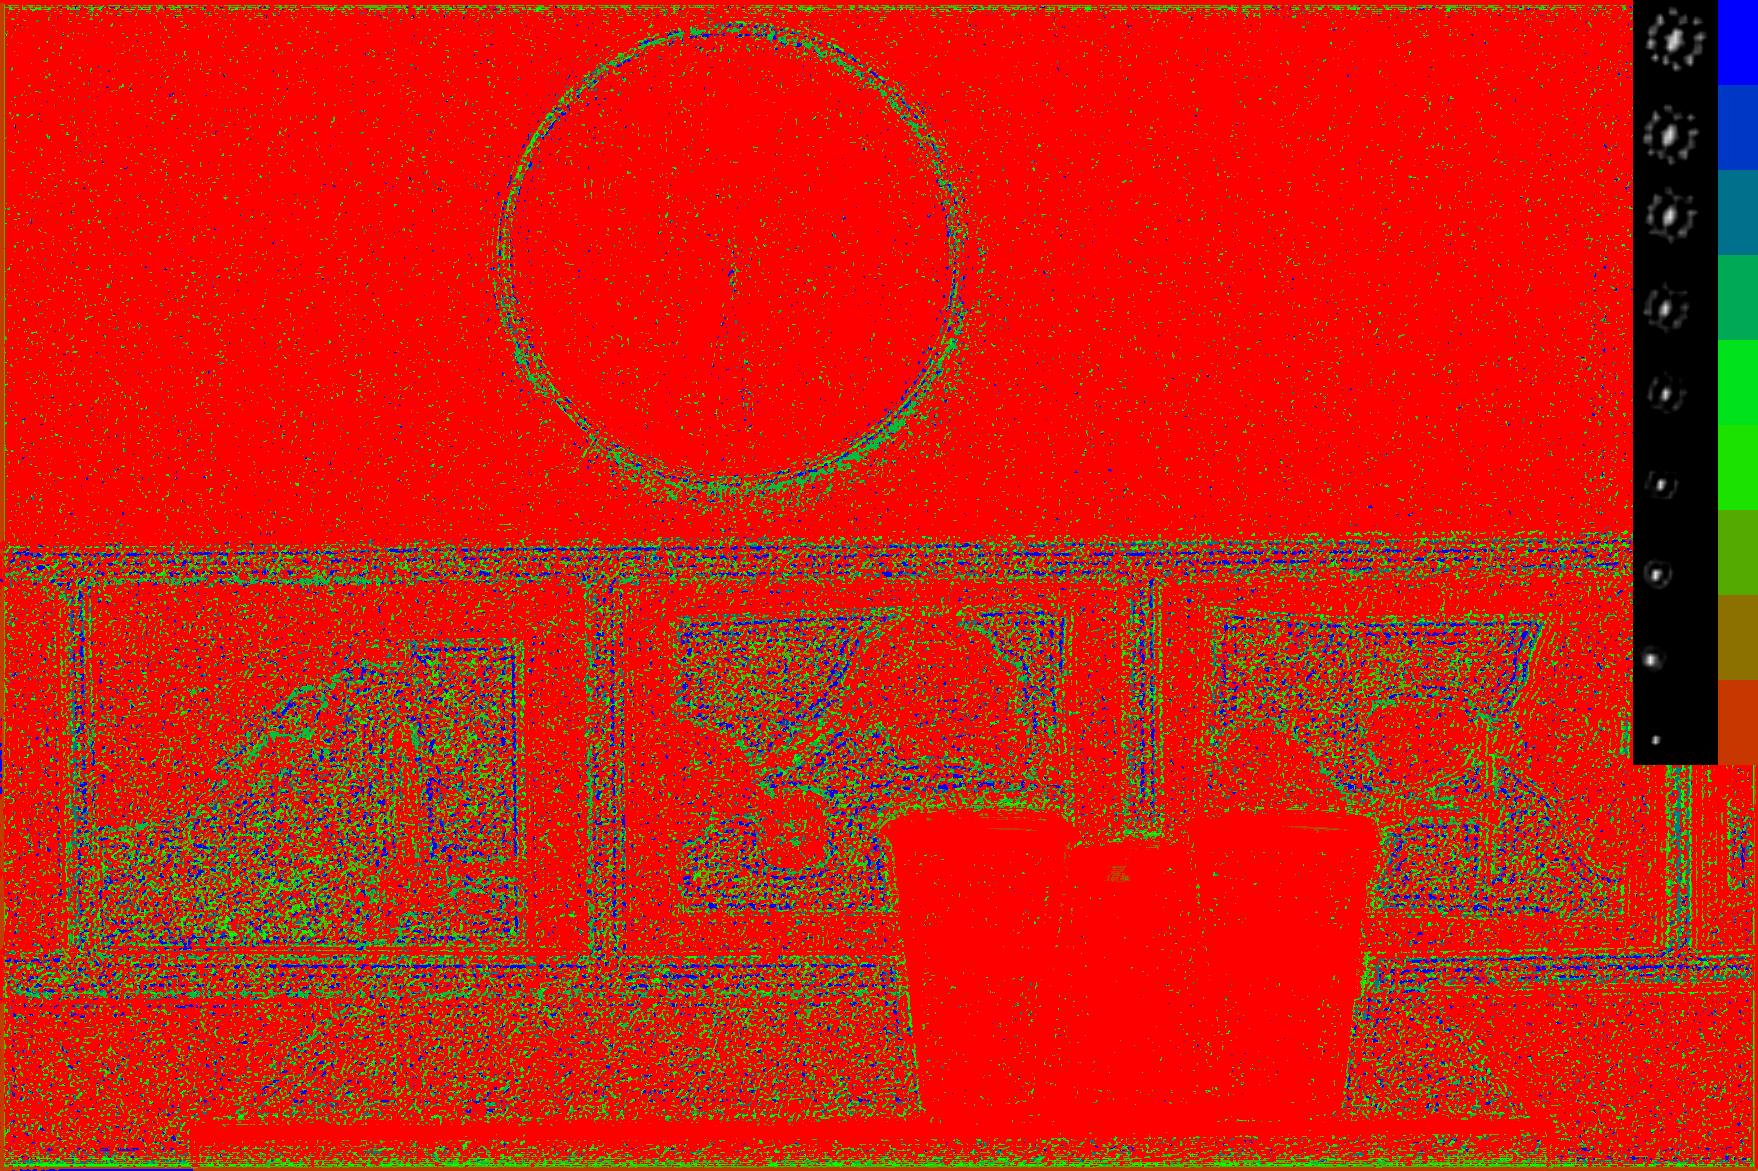

In [12]:
dbg_path = 'output/task4_L2_color.png'
legend = color_scale_legend(kernels)
(lh,lw,lc) = legend.shape
disp = display_contribution_map(contribution_map)
disp[:lh,-lw:] = legend
cv2.imwrite(dbg_path, disp)
Image(dbg_path)

Output for Sps color:

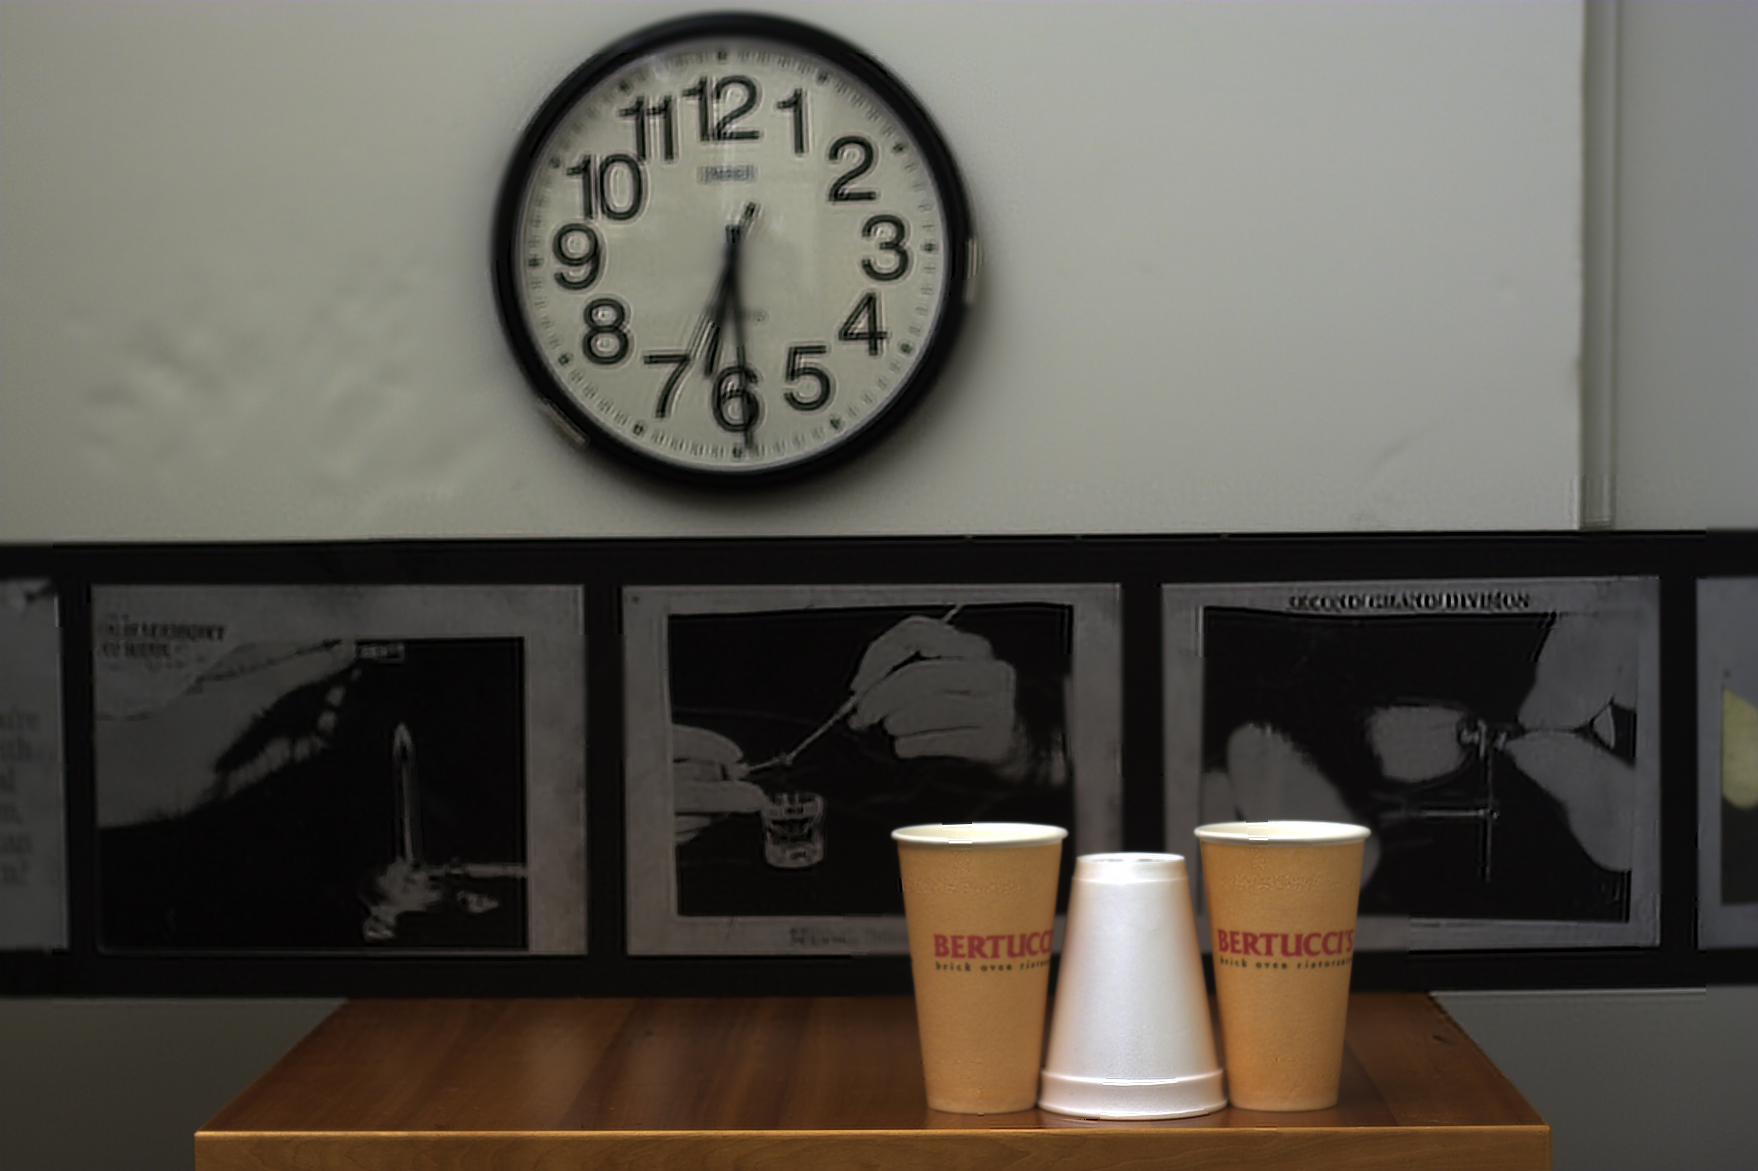

In [13]:
deconvs = np.array(outputs_Sps_color)
log_message("Computing reconstruction errors...")
approx_errors = compute_reconstruction_errors(image, kernels, deconvs, 101)
log_message("Computing reconstruction masks...")
contribution_map, masks = compute_reconstruction_masks(approx_errors)
log_message("Computing reconstructed image...")
output = compute_image_reconstruction(deconvs, masks)
output_path = 'output/task2.png'
cv2.imwrite(output_path, output)
Image(output_path)

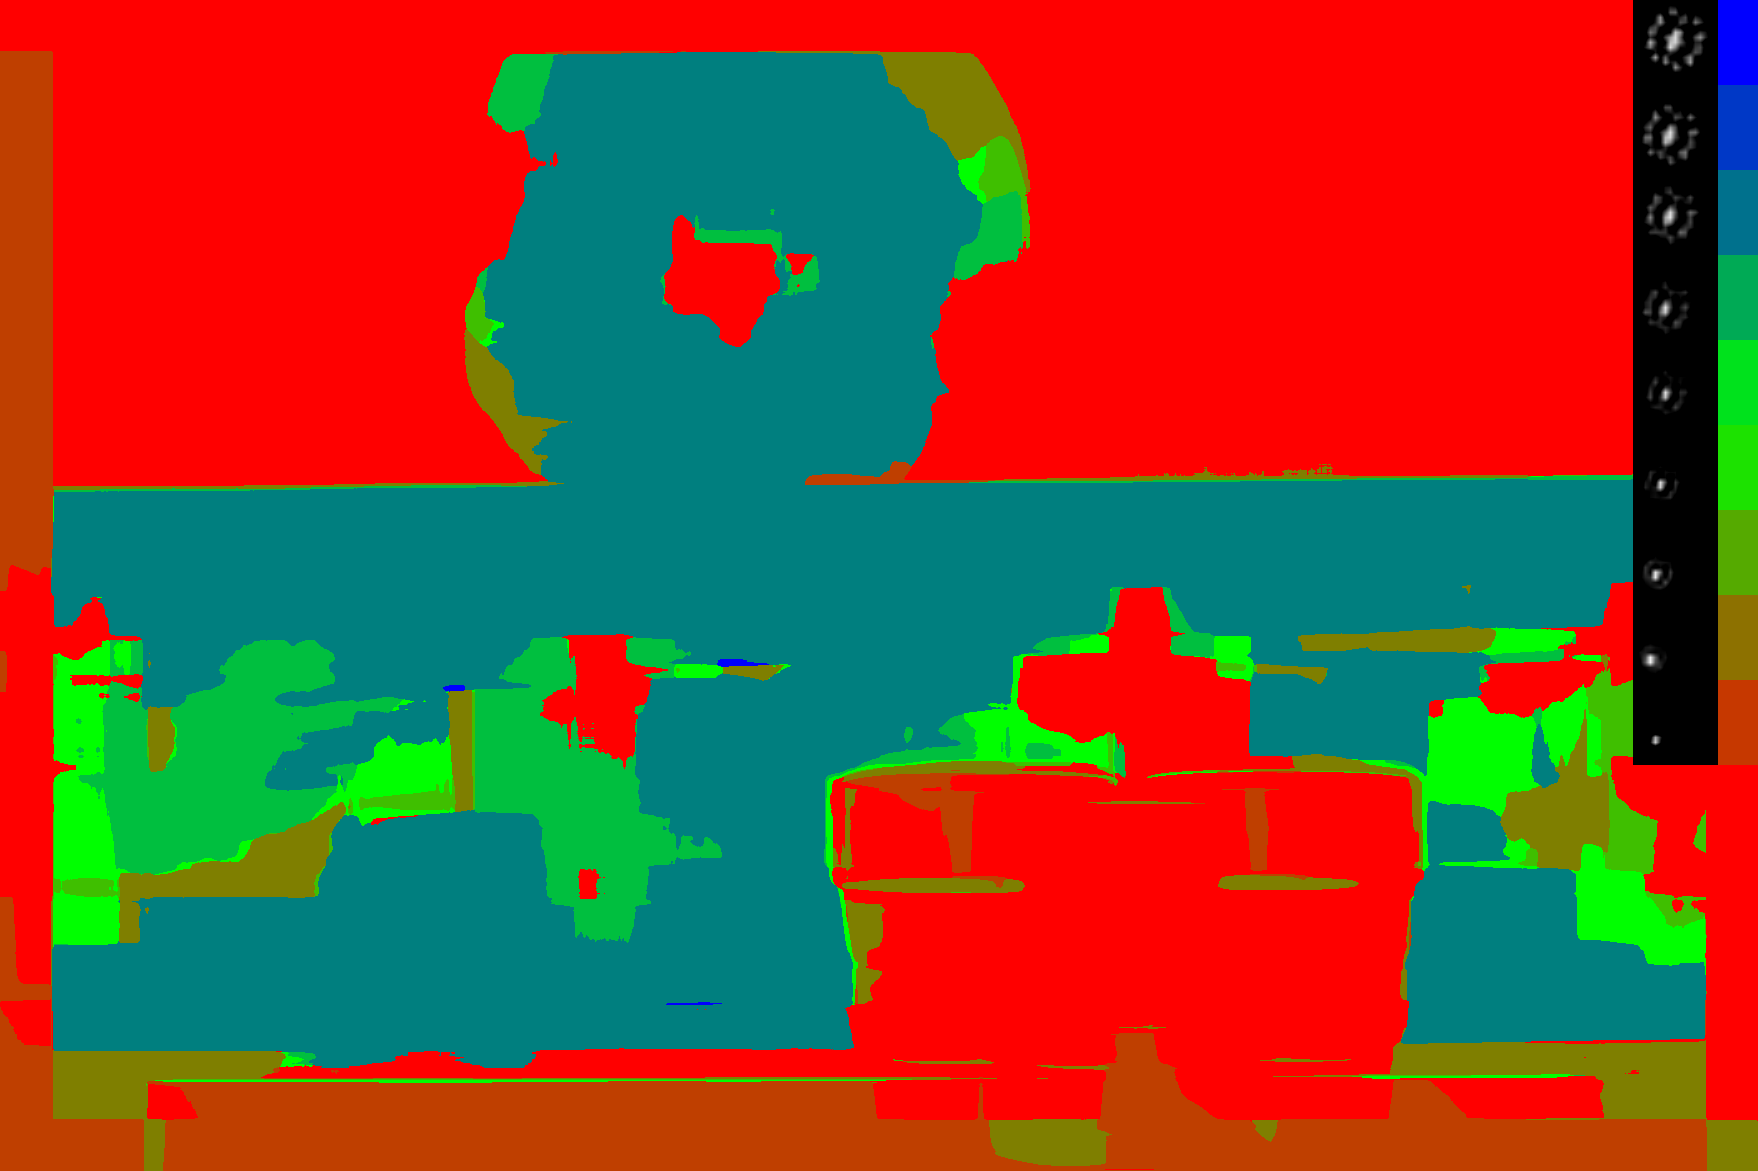

In [14]:
dbg_path = 'output/task4_Sps_color.png'
legend = color_scale_legend(kernels)
(lh,lw,lc) = legend.shape
disp = display_contribution_map(contribution_map)
disp[:lh,-lw:] = legend
cv2.imwrite(dbg_path, disp)
Image(dbg_path)